<br><br> 

# Notes

### KEY THEMES
- measuring uncertainties
- access
- uncertainty
- mistakes
- misclassifications
- rise in IUD mentions in the months after an uncertainty-causing event?

### FIGURES
- topics by birth control type
- regression + correlation of COVID terms and BC terms
- classification of flairs + hand labeling of misclassifications

<br><br>

# Imports + Functions

In [6]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)

import little_mallet_wrapper

In [7]:
data_path = '/Volumes/Passport-1/data/birth-control/scraped/all_posts.csv'

covid_keywords_path = '/Volumes/Passport-1/data/covid-keywords/covid_keywords_lazer_lab.tsv'

<br><br>

# Load data (if already found keywords)

In [8]:
posts_df = pd.read_csv('/Volumes/Passport-1/data/birth-control/scraped/all_posts.covid_and_bc_keywords.csv', 
                       converters={'COVID Keywords': eval, 'Birth Control Keywords': eval})

In [9]:
len(posts_df.index)

25818

In [10]:
posts_df.sample(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,author,created_utc,id,num_comments,score,selftext,subreddit,...,link_flair_text,is_video,Year,Month,COVID Keywords,"Contains Keyword: ""covid""","Contains Keyword: ""quarantine""",Birth Control Keywords,"Contains Keyword: ""pill""","Contains Keyword: ""iud"""
22433,85661,2187,2187,rosegoldrottweiler,1596955230,i6ew0v,1.0,1.0,Hello. I finished my last pack of birth contro...,birthcontrol,...,How to?,False,2020,8,[],False,False,[],False,False
158,63386,158,158,pinktriangle44,1580303618,evmpn8,2.0,1.0,Tried going off hormonal contraception after t...,birthcontrol,...,Experience,False,2020,1,[],False,False,[],False,False
2271,65499,2271,2271,needurhelp777,1578344739,el0b7t,2.0,1.0,So my girlfriend and I had sex without a condo...,birthcontrol,...,Mistake or Risk?,False,2020,1,[],False,False,"[pill, pill, pill]",True,False


<br><br>

# Load data

In [173]:
posts_df = pd.read_csv(data_path)

In [174]:
len(posts_df.index)

89046

In [175]:
posts_df = posts_df.dropna(subset=['created_utc'])

In [176]:
len(posts_df.index)

89042

In [177]:
def get_year(x):
    try: 
        return str(datetime.fromtimestamp(int(x)).year)
    except:
        return None


def get_month(x):
    try: 
        _month = str(datetime.fromtimestamp(int(x)).month)
        if len(_month) == 1:
            return '0' + str(datetime.fromtimestamp(int(x)).month)
        return str(datetime.fromtimestamp(int(x)).month)
    except:
        return None


def get_year_and_month(x):
    try: 
        _month = str(datetime.fromtimestamp(int(x)).month)
        if len(_month) == 1:
            return str(datetime.fromtimestamp(int(x)).year) + '-0' + str(datetime.fromtimestamp(int(x)).month)
        return str(datetime.fromtimestamp(int(x)).year) + '-' + str(datetime.fromtimestamp(int(x)).month)
    except:
        return None


posts_df['Year'] = posts_df['created_utc'].apply(get_year)
posts_df['Month'] = posts_df['created_utc'].apply(get_month)
posts_df['Year-Month'] = posts_df['created_utc'].apply(get_year_and_month)

In [178]:
posts_df = posts_df[(posts_df['Year'] == '2020') | (posts_df['Year'] == '2019')]

In [179]:
len(posts_df.index)

49655

In [180]:
posts_df.sample(3)

,Unnamed: 0,Unnamed: 0.1,author,created_utc,id,num_comments,score,selftext,subreddit,title,url,created,link_flair_text,is_video,Year,Month,Year-Month
54939,277,277,Lc1307,1561560698,c5qr6q,1.0,2.0,I haven’t been feeling like myself the past tw...,birthcontrol,Mood from depo wearing off affecting relations...,https://www.reddit.com/r/birthcontrol/comments...,1.561589e+09,Experience,False,2019,06,2019-06
79826,1898,1898,plantmama07,1591743130,gzycue,1.0,2.0,"I had my Skyla IUD removed last week, and now ...",birthcontrol,"After IUD removal, what does normal spotting l...",https://www.reddit.com/r/birthcontrol/comments...,1.591772e+09,Side effects!?,False,2020,06,2020-06
67298,1287,1287,Moonmxn1,1602904348,jcnvm0,2.0,1.0,"Hey guys, so I’ve been struggling to find a go...",birthcontrol,Need help!,https://www.reddit.com/r/birthcontrol/comments...,1.602933e+09,Other,False,2020,10,2020-10


In [182]:
posts_df['Year-Month'].unique()

array(['2019-01', '2019-10', '2019-11', '2019-12', '2019-02', '2019-03',
       '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
       '2020-01', '2020-10', '2020-02', '2020-03', '2020-04', '2020-05',
       '2020-06', '2020-07', '2020-08', '2020-09'], dtype=object)

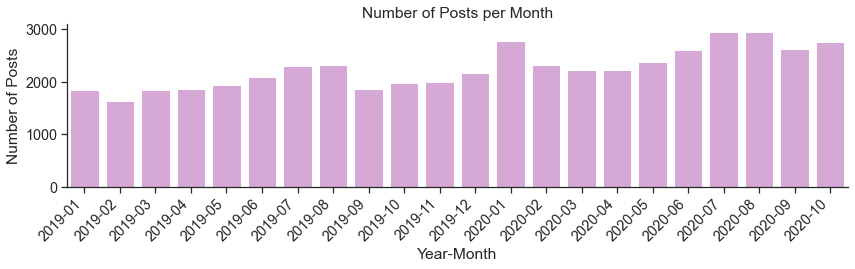

In [185]:
ordered_year_months = ['2019-01', '2019-02', '2019-03',
                       '2019-04', '2019-05', '2019-06', 
                       '2019-07', '2019-08', '2019-09',
                       '2019-10', '2019-11', '2019-12', 
                       '2020-01', '2020-02', '2020-03', 
                       '2020-04', '2020-05', '2020-06', 
                       '2020-07', '2020-08', '2020-09',
                       '2020-10']

sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(14,3))
sns.countplot(data=posts_df,
              x='Year-Month',
              color='plum',
              order=ordered_year_months)
plt.title('Number of Posts per Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
sns.despine()

<br><br>

# Load COVID keywords

In [186]:
covid_df = pd.read_csv(covid_keywords_path, sep='\t', names=['ngram', 'source'])

In [187]:
len(covid_df.index)

974

In [188]:
covid_df.sample(5)

,ngram,source
697,quarantaine,twitter_2020-05-13
593,medical mask,lazer_lab
740,reproduction number,lazer_lab
343,face mask,green_et_al | lazer_lab
916,workfromhome,twitter_2020-05-13


In [189]:
covid_keywords = covid_df['ngram'].tolist()

In [190]:
covid_keywords[:5]

['14dayquarantine', '2019_ncov', '2019ncov', '21dayslockdown', '5baje5minute']

<br><br>

# Find mentions of COVID keywords

In [191]:
def get_keywords(row, keywords):
    found_keywords = []
    text_to_search = str(row['selftext']).lower() + ' ' + str(row['title']).lower()
    for _keyword in keywords:
        _found_keywords = re.findall(r'\b' + _keyword.lower() + r'\b', text_to_search)
        found_keywords += _found_keywords
    return found_keywords

In [192]:
# test_df = posts_df.sample(100)
posts_df['COVID Keywords'] = posts_df.apply(lambda row: get_keywords(row, covid_keywords), axis=1)

In [193]:
posts_df.sample(3)

,Unnamed: 0,Unnamed: 0.1,author,created_utc,id,num_comments,score,selftext,subreddit,title,url,created,link_flair_text,is_video,Year,Month,Year-Month,COVID Keywords
57098,347,347,claudiarx3,1564168498,ci74q9,5.0,1.0,I’ve been on the Mirena IUD for 7 months. Over...,birthcontrol,Different Alternative to IUD?,https://www.reddit.com/r/birthcontrol/comments...,1.564197e+09,Which Method?,False,2019,07,2019-07,[]
66664,653,653,linskyaz,1603551250,jha8un,0.0,1.0,I was put on my first birth control about a ye...,birthcontrol,AUBRA EQ,https://www.reddit.com/r/birthcontrol/comments...,1.603580e+09,Other,False,2020,10,2020-10,[]
39479,88,88,HeIsTheDanger,1548824037,al96yp,5.0,1.0,TL;DR at the bottom.\n\nLittle bit of backgrou...,birthcontrol,Girlfriend is a different person since getting...,https://www.reddit.com/r/birthcontrol/comments...,1.548853e+09,Side Effects!?,False,2019,01,2019-01,[]


In [194]:
posts_df.to_csv('/Volumes/Passport-1/data/birth-control/scraped/all_posts.covid_keywords.csv')

<br><br>

# Find mentions of birth control keywords

In [143]:
bc_keywords = ['pill', 'iud', 'nexplanon', 'mirena', 'shot']

In [144]:
posts_df['Birth Control Keywords'] = posts_df.apply(lambda row: get_keywords(row, bc_keywords), axis=1)

In [147]:
posts_df.sample(5)

,Unnamed: 0,Unnamed: 0.1,author,created_utc,id,num_comments,score,selftext,subreddit,title,...,link_flair_text,is_video,Year,Month,COVID Keywords,"Contains Keyword: ""covid""","Contains Keyword: ""quarantine""",Birth Control Keywords,"Contains Keyword: ""pill""","Contains Keyword: ""iud"""
80018,2090,2090,BabyT113,1591551820,gygr0w,17.0,1.0,Is it possible? I’ve had the IUD in for almost...,birthcontrol,Pregnant with IUD,...,Experience,False,2020,6,[],False,False,"[iud, iud, iud]",False,True
67895,1884,1884,sandaraaa,1602422702,j95cto,3.0,1.0,So I started BC (combination pill) late June. ...,birthcontrol,Could I be pregnant or am I still adjusting?,...,Mistake or Risk?,False,2020,10,[],False,False,"[pill, pill]",True,False
72667,1570,1570,Bitchenella,1583749787,ffsnun,13.0,1.0,"Hi all! I'm still kinda new to reddit, first p...",birthcontrol,IUB Ballerine - personal experiences and opini...,...,Other,False,2020,3,[],False,False,[],False,False
65500,2272,2272,cantthinkofone09,1578344285,el07c3,10.0,1.0,"Hi, I’m currently considering a copper IUD and...",birthcontrol,Considering copper IUD,...,NaN,False,2020,1,[],False,False,"[pill, pill, pill, pill, iud, iud, iud, iud]",True,True
79896,1968,1968,StopRightMeoww,1591675355,gzfihe,2.0,1.0,"So, I haven't had any problems with IUDS in th...",birthcontrol,Overthinking about my IUD shifting and effecti...,...,Other,False,2020,6,[],False,False,"[iud, iud]",False,True


In [153]:
posts_df.to_csv('/Volumes/Passport-1/data/birth-control/scraped/all_posts.covid_and_bc_keywords.csv')

<br><br>

# Find mentions of access keywords

In [74]:
family_keywords = ['son', 'daughter', 'brother', 'sister', 'grandmother', 'grandfather', 'grandma', 'grandpa', 'aunt', 'uncle', 'cousin', 'sibling', 'mother', 'father', 'mom', 'dad', 'mum', 'parents']

partner_keywords = ['husband', 'wife', 'partner', 'spouse', 'boyfriend', 'girlfriend', 'bf', 'gf', 'in a relationship', 'married', 'dating']

medical_keywords = ['doctor', 'nurse', 'pharmacist']

access_keywords = ['insurance', 'discount', 'pharmacy', 'order online', 'online ordering', 'ordered online', 'prescription', 'refill', 'access', 'coverage', 'urgent care', 'emergency room', 'office', 'mail', 'health center', 'run out', 'provider', 'virtual', 'transportation', 'planned parenthood', 'clinic', 'hospital', 'appointment', 'insertion', 'permission', 'phone', 'internet', 'deliver', 'delivery']

In [75]:
posts_df['Family Keywords'] = posts_df.apply(lambda row: get_keywords(row, family_keywords), axis=1)

In [76]:
posts_df['Partner Keywords'] = posts_df.apply(lambda row: get_keywords(row, partner_keywords), axis=1)

In [44]:
posts_df['Medical Keywords'] = posts_df.apply(lambda row: get_keywords(row, medical_keywords), axis=1)

In [45]:
posts_df['Access Keywords'] = posts_df.apply(lambda row: get_keywords(row, access_keywords), axis=1)

In [92]:
posts_df.to_csv('/Volumes/Passport-1/data/birth-control/scraped/all_posts.covid_and_bc_and_access_keywords.csv')

In [91]:
posts_df.sample(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,author,created_utc,id,num_comments,score,selftext,subreddit,...,link_flair_text,is_video,Year,Month,COVID Keywords,Birth Control Keywords,Family Keywords,Partner Keywords,Medical Keywords,Access Keywords
3774,67002,991,991,emologue,1603270402,jf9a0p,0.0,1.0,Has anyone experienced any sort of slightly cl...,birthcontrol,...,Experience,False,2020,10,[],"[nexplanon, nexplanon]",[],[],[],[]
17502,80730,202,202,Rondie09,1596014386,hzxkwq,0.0,1.0,"Hi there, I’m 20F and I’m experiencing somethi...",birthcontrol,...,Side effects!?,False,2020,7,[],"[pill, pill, pill, pill, nexplanon, nexplanon,...",[],[],[],[]
5255,68483,2472,2472,Honey_Faucet,1601842168,j55m9e,1.0,1.0,"Hi all,\n\nI have a question just based on cur...",birthcontrol,...,Mistake or Risk?,False,2020,10,[],[pill],[],[],[],[]


<br><br>

# Visualize COVID keywords

In [11]:
keyword_count_dict = defaultdict(int)
for i, r in posts_df.iterrows():
    for _keyword in r['COVID Keywords']:
        keyword_count_dict[_keyword] += 1

In [12]:
for _keyword, _count in sorted(keyword_count_dict.items(), key=lambda x: x[1], reverse=True):
    print(_count, '\t', _keyword)

573 	 covid
295 	 quarantine
274 	 pandemic
148 	 covid-19
143 	 lockdown
102 	 coronavirus
88 	 corona
55 	 fda
45 	 the virus
37 	 swab
25 	 covid19
21 	 quarantined
18 	 nih
17 	 corona virus
13 	 working from home
13 	 covid 19
13 	 stay home
12 	 stay at home
12 	 social distancing
11 	 asymptomatic
8 	 wearing a mask
7 	 disinfect
7 	 wear a mask
6 	 outbreak
6 	 cdc
6 	 wfh
6 	 hand sanitizer
6 	 quarantining
6 	 staying home
5 	 this virus
5 	 lockdowns
4 	 disinfectant
4 	 lock down
4 	 shelter in place
3 	 epidemic
3 	 self isolation
3 	 work from home
3 	 staying at home
3 	 lysol
2 	 food and drug administration
2 	 re open
2 	 quarentine
2 	 reopen
2 	 furloughed
2 	 reopening
2 	 immunocompromised
2 	 re-open
2 	 dexamethasone
1 	 homeschool
1 	 oxygen saturation
1 	 panic buying
1 	 covd
1 	 quarantines
1 	 cv19
1 	 human trials
1 	 carona virus
1 	 self isolating
1 	 medical supplies
1 	 quarentined
1 	 the rona
1 	 ventilation
1 	 facemask
1 	 wearing masks
1 	 ppe
1 	

In [98]:
target_column = 'COVID Keywords'
for i, r in posts_df[posts_df[target_column].map(len) > 0].sample(1).iterrows():
    print(r['title'])
    print(r['selftext'])
    print(r[target_column])

Not gonna see my boyfriend for a while due to coronavirus, should I keep taking my BC?
I'm currently on my placebo week but I was wondering if I could take a small 2-3 week break after I finish this pack (it's my first pack). 

I only take bc to avoid pregnancy. 

I have two more packs and want to delay taking them because I use the pill club but don't live in the US so my sister gets my pills and ships them to me. I don't want to make her have to go to the post office during these times. 

Can I do this or should I still be taking my pills regardless?
['coronavirus']


In [132]:
def plot_keyword_frequency_over_time(df, target_column, target_keyword):
    sns.set(style='ticks', font_scale=1.3)
    plt.figure(figsize=(7,2.5))
    sns.countplot(data=posts_df[posts_df[target_column].apply(lambda x: target_keyword in x)],
                x='Month',
                color='plum',
                order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.title('Keyword: ' + target_keyword)
    plt.ylabel('Number of Posts')
    sns.despine()

In [117]:
def plot_all_keyword_frequency_over_time(df, target_column):
    sns.set(style='ticks', font_scale=1.3)
    plt.figure(figsize=(7,3))
    sns.countplot(data=posts_df[posts_df[target_column].map(len) > 0],
                x='Month',
                color='plum',
                order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.title(target_column)
    plt.ylabel('Number of Posts')
    sns.despine()

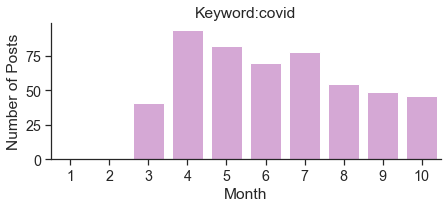

In [118]:
plot_keyword_frequency_over_time(posts_df, 'COVID Keywords', 'covid')

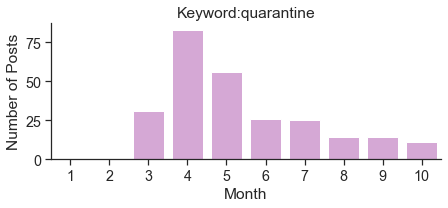

In [119]:
plot_keyword_frequency_over_time(posts_df, 'COVID Keywords', 'quarantine')

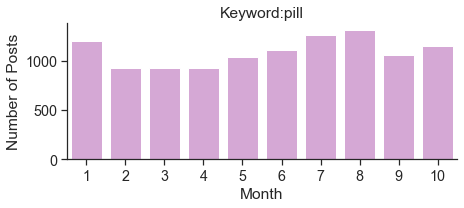

In [120]:
plot_keyword_frequency_over_time(posts_df, 'Birth Control Keywords', 'pill')

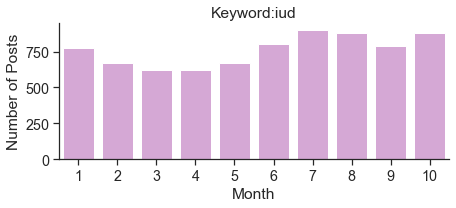

In [121]:
plot_keyword_frequency_over_time(posts_df, 'Birth Control Keywords', 'iud')

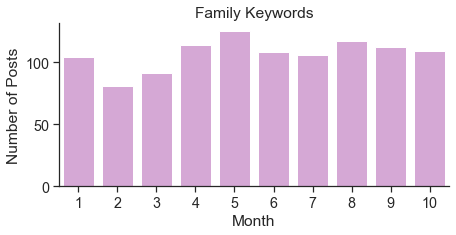

In [122]:
plot_all_keyword_frequency_over_time(posts_df, 'Family Keywords')

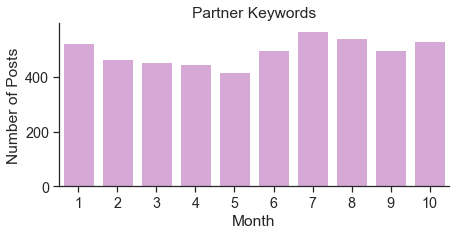

In [123]:
plot_all_keyword_frequency_over_time(posts_df, 'Partner Keywords')

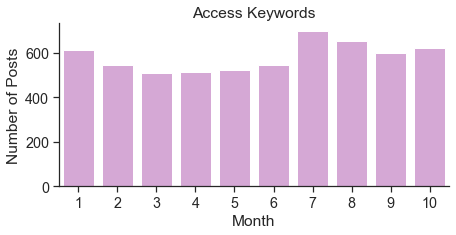

In [124]:
plot_all_keyword_frequency_over_time(posts_df, 'Access Keywords')

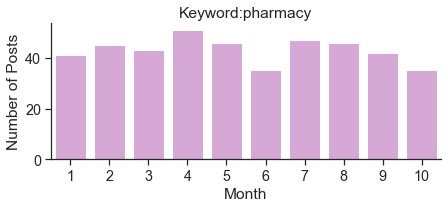

In [131]:
plot_keyword_frequency_over_time(posts_df, 'Access Keywords', 'pharmacy')

# Flairs by COVID keywords

In [32]:
posts_df['link_flair_text'].value_counts()

Side effects!?      7073
Experience          4862
Mistake or Risk?    4484
Other               2338
How to?             1937
Which Method?       1766
Side Effects!?      1083
Rant!                595
Educational          561
Which Method?         27
Name: link_flair_text, dtype: int64

In [33]:
flair_count_dict = defaultdict(int)
flair_covid_count_dict = defaultdict(int)
for i, r in posts_df.iterrows():
    flair_count_dict[str(r['link_flair_text']).strip()] += 1
    if len(r['COVID Keywords']):
        flair_covid_count_dict[str(r['link_flair_text']).strip()] += 1

In [34]:
flair_covid_percent_dict = {_flair: _count / float(flair_count_dict[_flair]) for _flair, _count in flair_covid_count_dict.items()}

In [35]:
for _flair, _percent in sorted(flair_covid_percent_dict.items(), key=lambda x: x[1], reverse=True):
    print(str(round(_percent*100, 1)) + '%', '\t', _flair)

8.1% 	 Rant!
6.6% 	 Experience
6.5% 	 Side effects!?
5.9% 	 Other
5.9% 	 Which Method?
5.3% 	 How to?
4.9% 	 Mistake or Risk?
3.6% 	 Educational
3.0% 	 Side Effects!?
2.7% 	 nan


<br><br>

# Keywords sandbox

In [51]:
# loss of insurance, money, discounts
# pharmacy, nurse, doctor, virtual visits, office visits, prescription, mail order (ACCESS)
# family mentions vs partner mentions
# uncertainty
# ... more morning after?
# weight changes during the pandemic
# 
# TODO: Fightin Words of covd vs non-covid posts
# TODO: use comments to predict flair (rather than just the post)

In [36]:
family_keywords = ['son', 'daughter', 'brother', 'sister', 'grandmother', 'grandfather', 'grandma', 'grandpa', 'aunt', 'uncle', 'cousin', 'sibling', 'mother', 'father', 'mom', 'dad', 'mum']

partner_keywords = ['husband', 'wife', 'partner', 'spouse', 'boyfriend', 'girlfriend', 'bf', 'gf', 'relationship', 'parents']

medical_keywords = ['doctor', 'nurse', 'pharmacist']

access_keywords = ['insurance', 'discount', 'pharmacy', 'order online', 'online ordering', 'ordered online', 'prescription', 'refill', 'access', 'coverage', 'urgent care', 'emergency room', 'office', 'mail', 'health center', 'run out', 'provider', 'virtual', 'transportation', 'planned parenthood', 'clinic', 'hospital', 'appointment', 'insertion', 'permission', 'phone', 'internet', 'deliver', 'delivery']

# access_keywords = ['insurance', 'discount', 'pharmacy', 'order online', 'online ordering', 'ordered birth control online', 'prescription', 'ordering online', '6 month', '3 month', 'six months', 'three months', 'order', 'ordered', 'ordering', 'refill', 'ship', 'access', 'coverage', 'urgent care', 'emergency room', 'office', 'mail', 'health center', 'run out', 'provider', 'delay', 'virtual', 'zoom', 'pending', 'transportation', 'ride', 'planned parenthood', 'clinic', 'hospital', 'appointment', 'wait', 'insertion', 'permission', 'phone', 'internet', 'deliver', 'delivery'] # but not "in order to"

In [64]:
target = 'virtual'
for i, r in posts_df.iterrows():
    if target in str(r['selftext']):
        print(r['selftext'].replace(target, '___' + target.upper() + '___'))
        print('\n\n===========================================\n\n')

I've been so happy with my IUD for years now. I had Skyla when I was in college and kept it in for about 3 years, and now I have Mirena because my OB said Skyla was phased out. 

Switching the IUDs was an ordeal — I'm VERY bad with pain and learned that I have a tilted uterus, so the nurse practitioner had a tough time and eventually an older doctor came in and practically had to hold me down to get it done. But other than that, there have been no issues lol. 

I've had this in since May 2018 with very little (if any) spotting. Sometimes just a little bit after sex. But ___VIRTUAL___ly no cramps. Last night out of nowhere, I got hit like a truck with terrible cramps. I took put a heating pad on and tried to just sleep, but woke up several times from the pain. I took 2 ibuprofen when I woke up and am having earl grey tea (used to do the trick in high school, pre-IUD days) and it's still extremely painful and uncomfortable. 

Could something be wrong with my IUD or is this normal?




Hi

In [58]:
for i, r in posts_df.iterrows():
    if 'order online' in str(r['selftext']):
        print(r['selftext'].replace('order online', '___ORDER ONLINE___'))
        print('\n\n===========================================\n\n')

She said that spermicide can weaken condoms and cause them to break. I'm using the symptothermal fertility awareness method, plus condoms, plus a diaphragm if i'm having sex within my fertile window. Well, according to my BBT, I ovulated 24hrs ago, and had a condom slip lastnight (we didnt notice and he didnt pull out). So, I'm scared to take out the diaphragm now because the sperm can live for up to 5 days inside me. But Caya advises I dont leave it in for more than 24 hrs. ALSO i'm trying to find somewhere to bye spermicide in-person today, and no one can help me. Not even planned parenthood. I can only ___ORDER ONLINE___ with it being shipped tomorrow night at the earliest. Not sure what to do...




Right now I'm in the process of trying to obtain a common law marriage with my boyfriend. However, I just now ran out of birthcontrol, and I've been trying to find some to ___ORDER ONLINE___ for a while that's not too sketchy. I usually take AubraEQ, and I'm at the point where I'm more 

In [59]:
for i, r in posts_df.iterrows():
    if 'run out' in str(r['selftext']):
        print(r['selftext'].replace('run out', '___RUN OUT___'))
        print('\n\n===========================================\n\n')

I recently went to inova primary care and got a regular physical check up and got my prescription for birth control sent to CVS, although I went to cvs and said there are only 6 refills. Will CVS have to call the dr office again to prescribe the other 6 months when I ___RUN OUT___ or can I call now when I still have 6 refills left? Or do I have to get another check up? Or am I suppose to call dr office?




I just did the math (adding in one week break for periods) and found out I will ___RUN OUT___ of patches on october 2nd. I recently switched from the pill to the patch with no break. My doctor had prescribed me 10 refills in total. I have 9 left.

Should I ask my doctor to refill more patches later on before my annual in November, or can I get my annual 2 months early and get a one year refill?




I am sorry if this makes no sense, I'm curled up on the floor with a heat pad withering in pain. 

I had my copper IUD placed back in June of 2019. The periods are pretty manageable, howe

In [55]:
for i, r in posts_df.iterrows():
    if 'access' in str(r['selftext']):
        print(r['selftext'].replace('access', '___ACCESS___'))
        print('\n\n===========================================\n\n')

Hello I had a regular gyn appointment on January 5th and I told her that I would like her to check my strings just for a peace of mind to make sure everything is in place. The last time I was sexually active was a week before this appointment and I always use condoms with my boyfriend we’ve never had a slip up or broken condom. 

So my question is did my NP still run a pregnancy test? When I ___ACCESS___ my chart online it doesn’t mention a pregnancy test but it shows my negative std test results so I’m confused. 

I’m concerned that I am pregnant but I know that all my symptoms are also symptoms of stress because I’m in university. My symptoms are insomnia, loss of appetite, diarrhea, frequent urination? (Once an hour), and fatigue during the day that I think is a result of insomnia. 

I know that the IUD is one of the most effective forms of birth control so also pairing that with my boyfriend pulling out and never even ejaculating inside the condom inside me I think I’m good? Also, 

In [56]:
for i, r in posts_df.iterrows():
    if 'coverage' in str(r['selftext']):
        print(r['selftext'].replace('coverage', '___COVERAGE___'))
        print('\n\n===========================================\n\n')

TLDR: has anyone had this excruciating period post Mirena IUD? Is this somewhat normal? 
I’m seeing my doctor tomorrow but wanted perspective on this. 

——-
I am on week two after getting my Mirena IUD. I genuinely thought everything was fine—-insertion was terrible but after that I had minimal cramping.

Then I started my period yesterday. Yesterday and today I am getting waves of unbelievable pain, where I can’t even stand and have to curl up into a ball. It makes me scream, and it is exhausting. It is mostly a stabbing pain on my left hip and tightness in my left leg. 

Luckily today these waves of excruciating pain are less frequent, but it comes out of no where and I feel like I can’t even breathe. I can feel the strings but they seem to be on the left side. This was my first time feeling the strings so I don’t know what is normal. 

I made an appointment with my doctor for tomorrow. I am posting to get some varied perspectives so I can make a decision about this iud. 

After the 

In [57]:
for i, r in posts_df.iterrows():
    if 'office' in str(r['selftext']):
        print(r['selftext'].replace('office', '___OFFICE___'))
        print('\n\n===========================================\n\n')

I very rarely post on Reddit, so consider this an example of how those with good experiences often just move on with their lives rather than post extensive horror stories online :) The reason I’m posting now is because I consulted this subreddit before my IUD replacement today and many of the posts I read scared me so much that I spent my whole week terrified of my appointment. I found one or two posts that didn’t seem so bad, and I clung to them. Hopefully this post might do that for someone else! 

I’ve avoided hormonal BC my whole life, out of an abundance of caution, due to my mother’s history of breast cancer. So I knew that the copper IUD, with its lack of hormones and its 12 year lifespan, was an awesome option for me. I got my first copper IUD 5 years ago in the UK (a Nova-T 380, with a 5-year lifespan). Before that appointment, I did the same thing and researched people’s experiences extensively online. The results were horrifying, as many of you have probably seen. I’m honest